In [1]:
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec


# Download necessary NLTK packages
try:
    nltk.download('stopwords')
    nltk.download('punkt_tab')
except Exception as e:
    print(f"Errore durante il download dei pacchetti NLTK: {e}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
df = pd.read_csv("../PreProcessing/processed_data/Resume_proc_lemm.csv")

In [3]:
# Get a list of stop word
stop_words = set(nltk.corpus.stopwords.words('english'))

In [4]:
def preprocess(text):
    tokens = word_tokenize(text.lower())
    return tokens

df['tokens'] = df['Resume_str'].apply(preprocess)

In [5]:
# Training Word2Vec sul campo 'tokens'
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=3, min_count=2, workers=4)

In [6]:
len(w2v_model.wv.index_to_key)

19857

In [7]:
def get_avg_vector(tokens, model, vector_size=100):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

df['vector'] = df['tokens'].apply(lambda x: get_avg_vector(x, w2v_model))

In [8]:
X = np.vstack(df['vector'].values)
y = df['Category']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)

In [10]:
# Print the sizes of the split datasets
print("Train data size:", X_train.shape)
print("Validation data size:", X_test.shape)

Train data size: (1738, 100)
Validation data size: (745, 100)


In [11]:
def smote(X_train, y_train):
    #print("Distribuzione delle classi nel training set prima di SMOTE:")
    # print(y_train.value_counts())
    
    # Identifica le classi minoritarie
    class_counts = y_train.value_counts()
    min_classes = class_counts[class_counts < 0.7*class_counts.mean()].index.tolist()
    
    if not min_classes:
        print("Nessuna classe minoritaria trovata. SMOTE non applicato.")
        return X_train, y_train

    print(f"Applicazione di SMOTE alle classi: {min_classes} \n")
    
    # Crea un dizionario per la strategia di campionamento
    target_size = int(class_counts.max())
    sampling_strategy = {cls: target_size for cls in min_classes}
    
    # Applica SMOTE
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # print("Distribuzione delle classi nel training set dopo SMOTE:")
    # print(pd.Series(y_train_resampled).value_counts())
    
    return X_train_resampled, y_train_resampled

In [12]:
X_train_resampled, y_train_resampled = smote(X_train, y_train)

Applicazione di SMOTE alle classi: ['AGRICULTURE', 'AUTOMOBILE', 'BPO'] 



In [13]:
print("Distribuzione delle classi dopo SMOTE:")
print(y_train_resampled.value_counts())

Distribuzione delle classi dopo SMOTE:
Category
AUTOMOBILE                84
BPO                       84
AGRICULTURE               84
INFORMATION-TECHNOLOGY    84
ENGINEERING               83
FINANCE                   83
ADVOCATE                  83
CHEF                      83
ACCOUNTANT                83
BUSINESS-DEVELOPMENT      83
AVIATION                  82
FITNESS                   82
SALES                     81
HEALTHCARE                81
BANKING                   80
CONSULTANT                80
CONSTRUCTION              78
PUBLIC-RELATIONS          78
HR                        77
DESIGNER                  75
ARTS                      72
TEACHER                   71
APPAREL                   68
DIGITAL-MEDIA             67
Name: count, dtype: int64


In [14]:
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: {results['mean_test_score'][candidate]:.3f} (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("")

In [15]:
skf = StratifiedKFold(n_splits=5)

In [16]:
'''RFC = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [100, 300, 700],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [6,7,8,9,10],
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= skf, scoring='accuracy', return_train_score=False, verbose=3, n_jobs=-1)

start = time()
grid_search = grid.fit(X_train_resampled, y_train_resampled)

print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")
report(grid_search.cv_results_) #'''

'RFC = RandomForestClassifier(random_state=42)\n\nparam_grid = { \n    \'n_estimators\': [100, 300, 700],\n    \'max_features\': [\'sqrt\', \'log2\'],\n    \'max_depth\' : [6,7,8,9,10],\n    \'criterion\' :[\'gini\', \'entropy\']\n}\n\ngrid = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= skf, scoring=\'accuracy\', return_train_score=False, verbose=3, n_jobs=-1)\n\nstart = time()\ngrid_search = grid.fit(X_train_resampled, y_train_resampled)\n\nprint(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_[\'params\'])} candidates parameter settings.\n")\nreport(grid_search.cv_results_) #'

In [17]:
# print(grid_search.best_params_)

In [18]:
'''
results = pd.DataFrame(grid_search.cv_results_)

filtered = results[
    (results['param_criterion'] == 'gini') & 
    (results['param_max_features'] == 'sqrt')
]

pvt = filtered.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_n_estimators'
)

import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(pvt, cmap='viridis', annot=True, ax=ax)
plt.title('Accuracy Score (criterion=gini, max_features=sqrt)')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show() 
'''

"\nresults = pd.DataFrame(grid_search.cv_results_)\n\nfiltered = results[\n    (results['param_criterion'] == 'gini') & \n    (results['param_max_features'] == 'sqrt')\n]\n\npvt = filtered.pivot_table(\n    values='mean_test_score',\n    index='param_max_depth',\n    columns='param_n_estimators'\n)\n\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\nf, ax = plt.subplots(figsize=(6, 5))\nsns.heatmap(pvt, cmap='viridis', annot=True, ax=ax)\nplt.title('Accuracy Score (criterion=gini, max_features=sqrt)')\nplt.xlabel('n_estimators')\nplt.ylabel('max_depth')\nplt.show() \n"

In [19]:
# best_model = grid_search.best_estimator_
# prediction = best_model.predict(X_test)

In [20]:
RF_Model_best = RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 700, max_depth=10, criterion='entropy', class_weight='balanced')
RF_Model_best.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features='log2', n_estimators=700,
                       random_state=42)

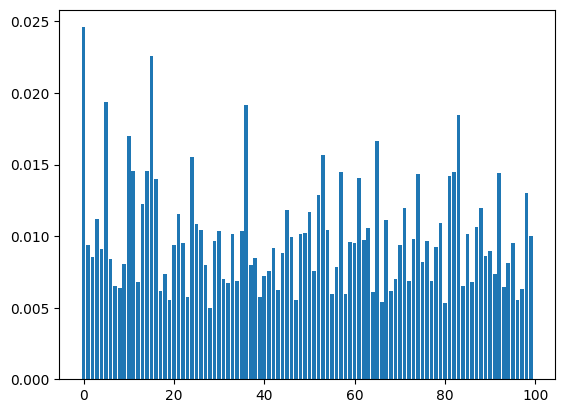

In [21]:
importances = RF_Model_best.feature_importances_
plt.bar(range(len(importances)), importances)
plt.show()

In [22]:
prediction = RF_Model_best.predict(X_test)

In [23]:
print(classification_report(y_test, prediction, target_names=df['Category'].unique()))

                        precision    recall  f1-score   support

                    HR       0.62      0.83      0.71        35
              DESIGNER       0.37      0.29      0.32        35
INFORMATION-TECHNOLOGY       0.21      0.26      0.23        19
               TEACHER       0.55      0.21      0.30        29
              ADVOCATE       0.22      0.13      0.16        31
  BUSINESS-DEVELOPMENT       0.20      0.27      0.23        11
            HEALTHCARE       0.36      0.34      0.35        35
               FITNESS       0.58      0.40      0.47        35
           AGRICULTURE       0.17      0.14      0.15         7
                   BPO       0.43      0.75      0.55        36
                 SALES       0.58      0.71      0.64        35
            CONSULTANT       0.62      0.59      0.61        34
         DIGITAL-MEDIA       0.00      0.00      0.00        35
            AUTOMOBILE       0.75      0.47      0.58        32
                  CHEF       0.57      

In [24]:
print("Training Score: {:.2f}".format(RF_Model_best.score(X_train_resampled, y_train_resampled)))
print("Test Score: {:.2f}".format(RF_Model_best.score(X_test, y_test)))

Training Score: 1.00
Test Score: 0.50


<Figure size 1500x1000 with 0 Axes>

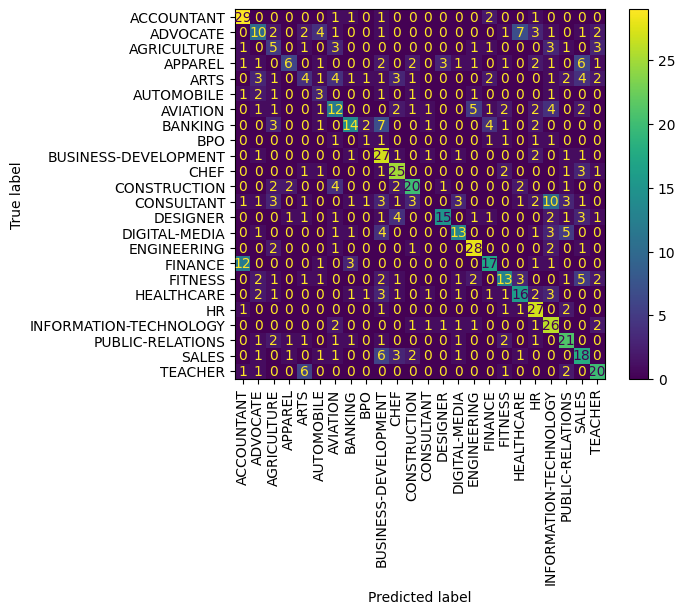

In [25]:
plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction)
plt.xticks(rotation=90)
plt.show()

In [26]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(RF_Model_best, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)

Cross-validation scores: [0.5026178  0.51706037 0.57480315 0.55643045 0.54330709]
